# UVIT view of Centaurus A; a detailed study on positive AGN feedback
## Jupyter notebooks used in the study: Notebook 1

We are making the scripts used for the study publicly available. This notebook is associated with the section 2.2 of the article. 

The scripts require the following packages installed.
  - numpy
  - pip
  - pandas
  - matplotlib
  - scipy
  - astropy
  - astroquery
  - photutils
  - dust_extinction

The cell below enable jupyter widget for matplotlib. It can produce interactive matplotlib inline plots. Please comment it if you do not have it installed. 

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

from scipy import stats
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astroquery.xmatch import XMatch
from astropy.coordinates import SkyCoord
from astropy.table import join, Table, setdiff
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip
from photutils.background import Background2D, SExtractorBackground
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from dust_extinction.parameter_averages import F99

Could not import regions, which is required for some of the functionalities of this module.


Here, it is assumed that you have downloaded the data provided at https://github.com/prajwel/Centaurus-A_NSR. Provide the data path to the variable `where_is_data`. Note that all NUV images have been aligned to F148W image using reproject.

In [3]:
where_is_data = 'data/'
F148W_hdu = fits.open(where_is_data + 'wcs_AS1G08_023T01_9000001978uvtFIIPC00F1A_l2imb.fits.gz')
F148W_error_hdu = fits.open(where_is_data + 'wcs_AS1G08_023T01_9000001978uvtFIIPC00F1A_l2erb.fits.gz')

N219M_hdu = fits.open(where_is_data + 'aligned_wcs_AS1G08_023T01_9000001978uvtNIIPC00F2A_l2imb.fits.gz')
N219M_error_hdu = fits.open(where_is_data + 'aligned_wcs_AS1G08_023T01_9000001978uvtNIIPC00F2A_l2erb.fits.gz')

N245M_hdu = fits.open(where_is_data + 'aligned_wcs_AS1G08_023T01_9000001978uvtNIIPC00F3A_l2imb.fits.gz')
N245M_error_hdu = fits.open(where_is_data + 'aligned_wcs_AS1G08_023T01_9000001978uvtNIIPC00F3A_l2erb.fits.gz')

N279N_hdu = fits.open(where_is_data + 'aligned_wcs_AS1G08_023T01_9000001978uvtNIIPC00F6A_l2imb.fits.gz')
N279N_error_hdu = fits.open(where_is_data + 'aligned_wcs_AS1G08_023T01_9000001978uvtNIIPC00F6A_l2erb.fits.gz')

color_excess_hdu = fits.open(where_is_data + 'aligned_p082Dust.fits.gz')

fuv_filters = pd.read_csv(where_is_data + '2020calpaper_uvit_FUV_filter_EA.txt', delim_whitespace=True)
nuv_filters = pd.read_csv(where_is_data + '2020calpaper_uvit_NUV_filter_EA.txt', delim_whitespace=True)

F148W_wcs = WCS(F148W_hdu[0].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
# To print the plate scale
(F148W_wcs.proj_plane_pixel_scales()[1].to(u.arcsec) + F148W_wcs.proj_plane_pixel_scales()[0].to(u.arcsec)) / 2

<Quantity 0.41685764 arcsec>

In [5]:
def data_cutout(hdu):
    cutout = Cutout2D(hdu[0].data, 
                      position = position, 
                      size = size, 
                      wcs = F148W_wcs)
    return cutout

In [6]:
def flux_to_mag(calibrated_flux, filter_lambda):
    mag = -2.5 * np.log10(calibrated_flux * filter_lambda ** 2 / (3e8 * 1e10)) - 48.6
    return mag

def mag_to_flux(mag, filter_lambda):
    calibrated_flux = ((3e8 * 1e10) / (filter_lambda ** 2)) * (10 ** ((mag + 48.6) / -2.5))
    return calibrated_flux

In [7]:
F148W_correction = 0.779
N219M_correction = 0.540
N245M_correction = 0.805
N279N_correction = 0.848

F148W = fuv_filters[fuv_filters['Filtername'] == 'F148W']
N219M = nuv_filters[nuv_filters['Filtername'] == 'N219M']
N245M = nuv_filters[nuv_filters['Filtername'] == 'N245M']
N279N = nuv_filters[nuv_filters['Filtername'] == 'N279N']

F148W_EA_corrected = F148W['EA(cm2)'] * F148W_correction
N219M_EA_corrected = N219M['EA(cm2)'] * N219M_correction
N245M_EA_corrected = N245M['EA(cm2)'] * N245M_correction
N279N_EA_corrected = N279N['EA(cm2)'] * N279N_correction

def filter_weighted_ext(wavelength, effective_area, flux_ext_factors):
    weighted_flux_ext_factors = flux_ext_factors * effective_area
    numerator = np.trapz(weighted_flux_ext_factors, x = wavelength)
    denominator = np.trapz(effective_area, x = wavelength)
    filter_weighted_extinction = numerator / denominator
    return filter_weighted_extinction

In [8]:
position = SkyCoord('13:26:16.9588 -42:51:36.902', frame='icrs', unit=(u.hourangle, u.deg))
size = (16.99948 * u.arcmin, 14.07162 * u.arcmin)

# Calculating Alambda.
F148W_lambda = 1481  # Angstrom
N219M_lambda = 2196  # Angstrom
N245M_lambda = 2447  # Angstrom
N279N_lambda = 2792  # Angstrom

# We will use Schlafly, E.F. & Finkbeiner, D.P.  2011, ApJ 737, 103 to correct for Galactic extinction. 
# datatag: ADS/IRSA.Dust#2022/0521/052329_28903
f99_ext = F99(Rv = 3.1)
color_excess_data = data_cutout(color_excess_hdu).data
print('median colour excess = {:.3f}'.format(np.median(color_excess_data)))
print('standard deviation of colour excess = {:.3f}'.format(np.std(color_excess_data)))
Ebv = 0.86 * color_excess_data
Ebv = np.median(Ebv)

F148W_flux_ext_factors = 1 / f99_ext.extinguish(F148W['#Wavelength(A)'].to_numpy() * u.AA, Ebv = Ebv)
N219M_flux_ext_factors = 1 / f99_ext.extinguish(N219M['#Wavelength(A)'].to_numpy() * u.AA, Ebv = Ebv)
N245M_flux_ext_factors = 1 / f99_ext.extinguish(N245M['#Wavelength(A)'].to_numpy() * u.AA, Ebv = Ebv)
N279N_flux_ext_factors = 1 / f99_ext.extinguish(N279N['#Wavelength(A)'].to_numpy() * u.AA, Ebv = Ebv)

F148W_flux_ext = filter_weighted_ext(F148W['#Wavelength(A)'], F148W_EA_corrected, F148W_flux_ext_factors)
N219M_flux_ext = filter_weighted_ext(N219M['#Wavelength(A)'], N219M_EA_corrected, N219M_flux_ext_factors)
N245M_flux_ext = filter_weighted_ext(N245M['#Wavelength(A)'], N245M_EA_corrected, N245M_flux_ext_factors)
N279N_flux_ext = filter_weighted_ext(N279N['#Wavelength(A)'], N279N_EA_corrected, N279N_flux_ext_factors)

# To estimate Unit Conversion values.
F148W_ZP = 18.097
N219M_ZP = 16.654  
N245M_ZP = 18.452
N279N_ZP = 16.416  

F148W_UC = (10 ** ((F148W_ZP + 48.6) / -2.5)) * 3e8 * 1e10/ (F148W_lambda ** 2)
N219M_UC = (10 ** ((N219M_ZP + 48.6) / -2.5)) * 3e8 * 1e10/ (N219M_lambda ** 2)
N245M_UC = (10 ** ((N245M_ZP + 48.6) / -2.5)) * 3e8 * 1e10/ (N245M_lambda ** 2)
N279N_UC = (10 ** ((N279N_ZP + 48.6) / -2.5)) * 3e8 * 1e10/ (N279N_lambda ** 2)

# distance to centaurus A. 
distance = 3.8 #mpc
pixel_scale = 0.416858 #arcseconds
pixelscale_in_Kpc = distance * 1e3 * np.deg2rad(pixel_scale / 3600)
pixelarea_in_kpc = pixelscale_in_Kpc ** 2

median colour excess = 0.104
standard deviation of colour excess = 0.006


In [9]:
F148W_data = data_cutout(F148W_hdu).data 
F148W_error_data = data_cutout(F148W_error_hdu).data 

N219M_data = data_cutout(N219M_hdu).data 
N219M_error_data = data_cutout(N219M_error_hdu).data 

N245M_data = data_cutout(N245M_hdu).data 
N245M_error_data = data_cutout(N245M_error_hdu).data 

N279N_data = data_cutout(N279N_hdu).data 
N279N_error_data = data_cutout(N279N_error_hdu).data 

In [10]:
sigma_clip = SigmaClip(sigma = 3., maxiters = 10)
bkg_estimator = SExtractorBackground()

F148W_bkg = Background2D(F148W_data, (400, 400), filter_size = (3, 3), sigma_clip = sigma_clip,
                       bkg_estimator = bkg_estimator)
N219M_bkg = Background2D(N219M_data, (400, 400), filter_size = (3, 3), sigma_clip = sigma_clip,
                       bkg_estimator = bkg_estimator)
N245M_bkg = Background2D(N245M_data, (400, 400), filter_size = (3, 3), sigma_clip = sigma_clip,
                       bkg_estimator = bkg_estimator)
N279N_bkg = Background2D(N279N_data, (400, 400), filter_size = (3, 3), sigma_clip = sigma_clip,
                       bkg_estimator = bkg_estimator)


F148W_threshold = 1.5 * F148W_bkg.background_rms  # above the background
F148W_sigma = (1.4 / pixel_scale) * gaussian_fwhm_to_sigma  # FUV FWHM = 1.4 arcseconds
F148W_kernel = Gaussian2DKernel(F148W_sigma)
F148W_segm = detect_sources(F148W_data - F148W_bkg.background, F148W_threshold, 
                          npixels = 5, 
                          connectivity = 8, 
                          kernel = F148W_kernel)

F148W_segm_deblend = deblend_sources(F148W_data - F148W_bkg.background, F148W_segm, 
                                   npixels = 5,
                                   nlevels = 32,
                                   contrast = 0.001, 
                                   kernel = F148W_kernel,
                                   connectivity = 8)

4.234454536344856e-05 5.1908379967482024e-05
4.711704716995152e-05 4.926216774411939e-05


Text(0.5, 1.0, 'Background RMS')

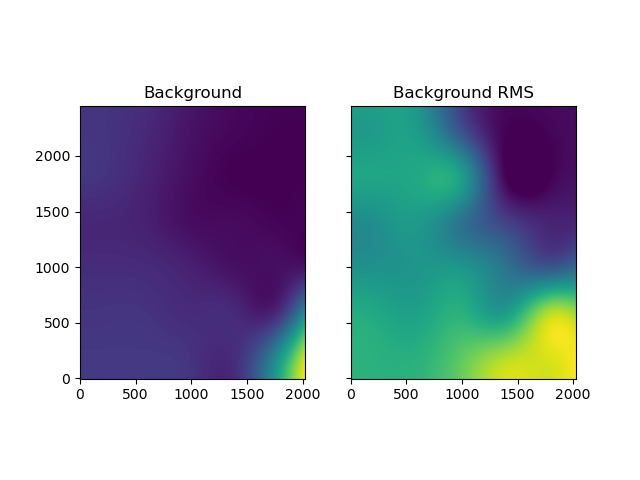

In [11]:
print(np.min(F148W_bkg.background), np.max(F148W_bkg.background))
print(np.min(F148W_bkg.background_rms), np.max(F148W_bkg.background_rms))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
ax1.imshow(F148W_bkg.background, origin = 'lower')
ax2.imshow(F148W_bkg.background_rms, origin = 'lower')

ax1.set_title('Background')
ax2.set_title('Background RMS')

3.1313217420129965e-05 3.662495218822774e-05
2.7696572461187138e-05 3.097664710703562e-05


Text(0.5, 1.0, 'Background RMS')

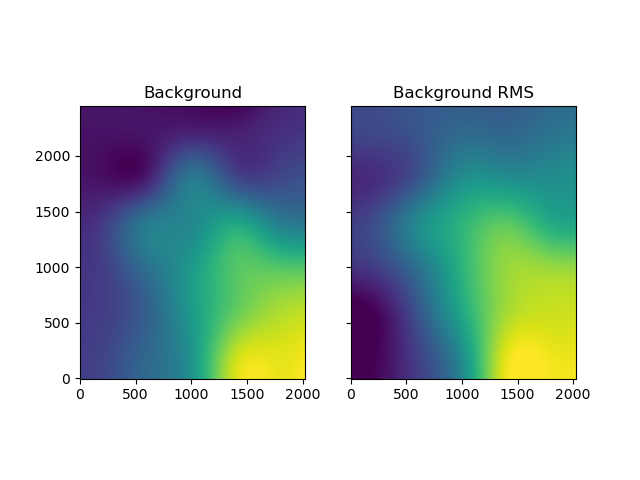

In [12]:
print(np.min(N219M_bkg.background), np.max(N219M_bkg.background))
print(np.min(N219M_bkg.background_rms), np.max(N219M_bkg.background_rms))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
ax1.imshow(N219M_bkg.background, origin = 'lower')
ax2.imshow(N219M_bkg.background_rms, origin = 'lower')

ax1.set_title('Background')
ax2.set_title('Background RMS')

3.824935630519055e-05 7.246661313667753e-05
9.745840915122847e-05 0.00012384686734284066


Text(0.5, 1.0, 'Background RMS')

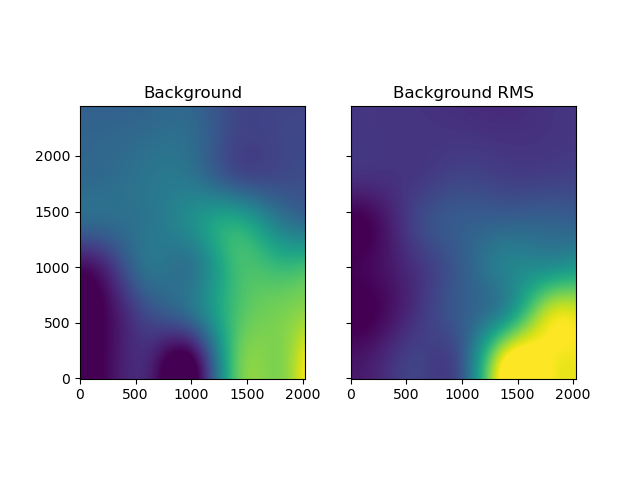

In [13]:
print(np.min(N245M_bkg.background), np.max(N245M_bkg.background))
print(np.min(N245M_bkg.background_rms), np.max(N245M_bkg.background_rms))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
ax1.imshow(N245M_bkg.background, origin = 'lower')
ax2.imshow(N245M_bkg.background_rms, origin = 'lower')

ax1.set_title('Background')
ax2.set_title('Background RMS')

3.36433042423488e-05 5.1799040618027316e-05
3.826894224138692e-05 4.524423172084869e-05


Text(0.5, 1.0, 'Background RMS')

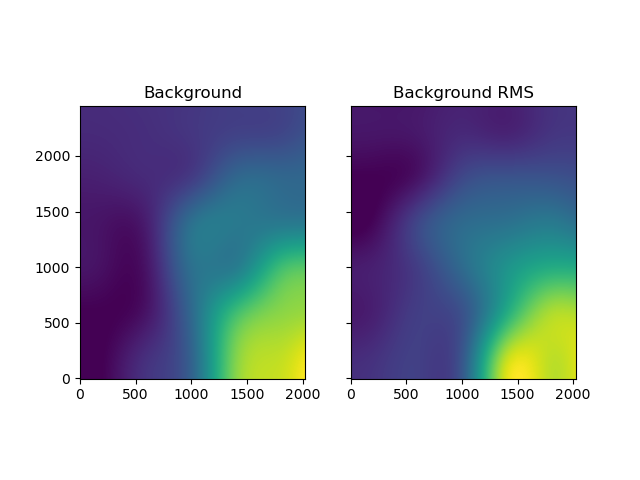

In [14]:
print(np.min(N279N_bkg.background), np.max(N279N_bkg.background))
print(np.min(N279N_bkg.background_rms), np.max(N279N_bkg.background_rms))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
ax1.imshow(N279N_bkg.background, origin = 'lower')
ax2.imshow(N279N_bkg.background_rms, origin = 'lower')

ax1.set_title('Background')
ax2.set_title('Background RMS')

Text(0.5, 1.0, 'Segmentation Image')

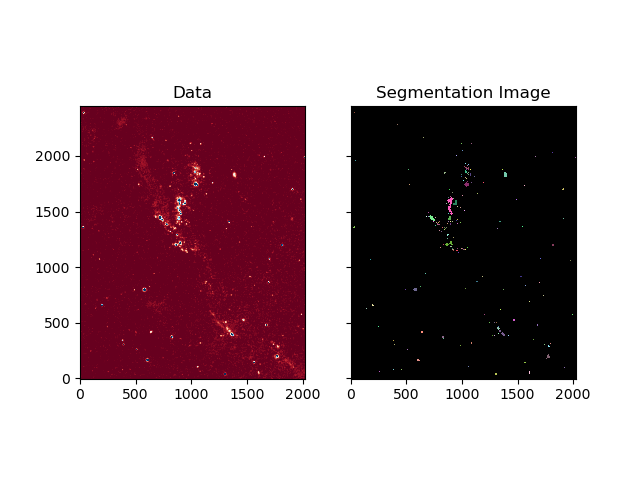

In [15]:
F148W_smoothed_data_for_visualization = convolve(F148W_data, F148W_kernel)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)

ax1.imshow(F148W_smoothed_data_for_visualization - F148W_bkg.background, 
           origin ='lower', 
           cmap = 'RdBu', 
           vmin = 0.5 * np.mean(F148W_bkg.background_rms),
           vmax = 5 * np.mean(F148W_bkg.background_rms))

ax1.set_title('Data')

cmap = F148W_segm.make_cmap(seed = 123)
ax2.imshow(F148W_segm, 
           origin = 'lower', 
           cmap = cmap, 
           interpolation = 'nearest')

ax2.set_title('Segmentation Image')

Text(0.5, 1.0, 'Deblended Segmentation Image')

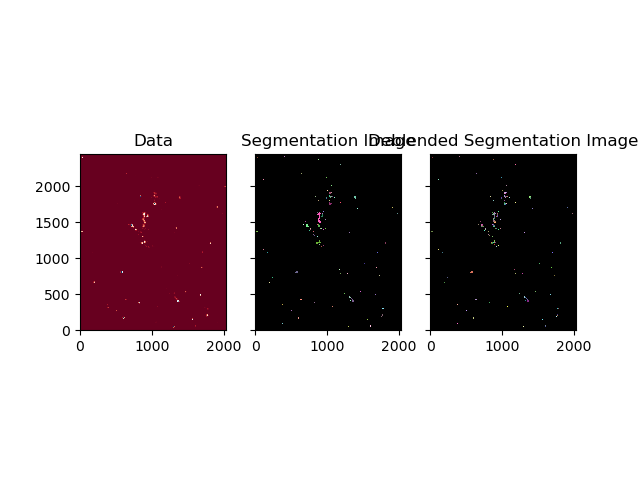

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex = True, sharey = True)

ax1.imshow(F148W_smoothed_data_for_visualization - F148W_bkg.background, 
           origin ='lower', 
           cmap = 'RdBu', 
           vmin = 1 * np.mean(F148W_bkg.background_rms),
           vmax = 10 * np.mean(F148W_bkg.background_rms))

ax1.set_title('Data')

cmap = F148W_segm.make_cmap(seed = 123)
ax2.imshow(F148W_segm, 
           origin = 'lower', 
           cmap = cmap, 
           interpolation = 'nearest')

ax2.set_title('Segmentation Image')

cmap = F148W_segm_deblend.make_cmap(seed = 123)
ax3.imshow(F148W_segm_deblend, 
           origin = 'lower', 
           cmap = cmap, 
           interpolation = 'nearest')

ax3.set_title('Deblended Segmentation Image')

In [17]:
#F148W
F148W_total_error_data = np.sqrt(np.square(F148W_error_data) + np.square(F148W_bkg.background_rms))
F148W_cat = SourceCatalog(F148W_data - F148W_bkg.background, F148W_segm_deblend, 
                          background = F148W_bkg.background, 
                          kron_params = (1.0, 0.0001), # ~0 second parameter to avoid using circular apertures. 
                          wcs = data_cutout(F148W_hdu).wcs, 
                          error = F148W_total_error_data)

F148W_tbl = F148W_cat.to_table()
F148W_tbl['RA_J2000'] = F148W_tbl['sky_centroid'].ra.degree
F148W_tbl['DEC_J2000'] = F148W_tbl['sky_centroid'].dec.degree
F148W_tbl['gini'] = F148W_cat.gini
F148W_tbl['fwhm'] = F148W_cat.fwhm.value * pixel_scale
F148W_tbl['elongation'] = F148W_cat.elongation.value

# For flux, multiply cps to unit conversion factor (erg/s/cm2/A).
F148W_tbl['calibrated_flux'] = F148W_tbl['segment_flux'] * F148W_UC 
F148W_tbl['calibrated_fluxerr'] = F148W_tbl['segment_fluxerr'] * F148W_UC


F148W_tbl['ext_corrected_flux'] = F148W_tbl['calibrated_flux'] * F148W_flux_ext
F148W_tbl['ext_corrected_fluxerr'] = F148W_tbl['calibrated_fluxerr'] * F148W_flux_ext

F148W_tbl['area_kpc_square'] = F148W_tbl['area'].value * pixelarea_in_kpc

F148W_tbl = F148W_tbl['label', 'RA_J2000', 'DEC_J2000', 
                      'calibrated_flux', 'calibrated_fluxerr', 
                      'ext_corrected_flux', 'ext_corrected_fluxerr', 
                      'gini', 'fwhm', 'elongation', 'area_kpc_square']

for colname in F148W_tbl.colnames:
    if colname not in ['label', 'RA_J2000', 'DEC_J2000']:
        F148W_tbl[colname].name = 'F148W_' + colname

In [18]:
#N219M
N219M_total_error_data = np.sqrt(np.square(N219M_error_data) + np.square(N219M_bkg.background_rms))
N219M_cat = SourceCatalog(N219M_data - N219M_bkg.background, F148W_segm_deblend, 
                          background = N219M_bkg.background, 
                          kron_params = (1.0, 0.0001), 
                          wcs = data_cutout(N219M_hdu).wcs, 
                          error = N219M_total_error_data)

N219M_tbl = N219M_cat.to_table()

# For flux, multiply cps to unit conversion factor (erg/s/cm2/A).
N219M_tbl['calibrated_flux'] = N219M_tbl['segment_flux'] * N219M_UC 
N219M_tbl['calibrated_fluxerr'] = N219M_tbl['segment_fluxerr'] * N219M_UC

N219M_tbl['ext_corrected_flux'] = N219M_tbl['calibrated_flux'] * N219M_flux_ext
N219M_tbl['ext_corrected_fluxerr'] = N219M_tbl['calibrated_fluxerr'] * N219M_flux_ext

N219M_tbl = N219M_tbl['label', 
                      'calibrated_flux', 'calibrated_fluxerr', 
                      'ext_corrected_flux', 'ext_corrected_fluxerr', 
                     ]

for colname in N219M_tbl.colnames:
    if colname not in ['label']:
        N219M_tbl[colname].name = 'N219M_' + colname

In [19]:
#N245M
N245M_total_error_data = np.sqrt(np.square(N245M_error_data) + np.square(N245M_bkg.background_rms))
N245M_cat = SourceCatalog(N245M_data - N245M_bkg.background, F148W_segm_deblend, 
                          background = N245M_bkg.background, 
                          kron_params = (1.0, 0.0001), 
                          wcs = data_cutout(N245M_hdu).wcs, 
                          error = N245M_total_error_data)

N245M_tbl = N245M_cat.to_table()

# For flux, multiply cps to unit conversion factor (erg/s/cm2/A).
N245M_tbl['calibrated_flux'] = N245M_tbl['segment_flux'] * N245M_UC 
N245M_tbl['calibrated_fluxerr'] = N245M_tbl['segment_fluxerr'] * N245M_UC

N245M_tbl['ext_corrected_flux'] = N245M_tbl['calibrated_flux'] * N245M_flux_ext
N245M_tbl['ext_corrected_fluxerr'] = N245M_tbl['calibrated_fluxerr'] * N245M_flux_ext

N245M_tbl = N245M_tbl['label', 
                      'calibrated_flux', 'calibrated_fluxerr', 
                      'ext_corrected_flux', 'ext_corrected_fluxerr', 
                     ]

for colname in N245M_tbl.colnames:
    if colname not in ['label']:
        N245M_tbl[colname].name = 'N245M_' + colname

In [20]:
#N279N
N279N_total_error_data = np.sqrt(np.square(N279N_error_data) + np.square(N279N_bkg.background_rms))
N279N_cat = SourceCatalog(N279N_data - N279N_bkg.background, F148W_segm_deblend, 
                          background = N279N_bkg.background, 
                          kron_params = (1.0, 0.0001), 
                          wcs = data_cutout(N279N_hdu).wcs, 
                          error = N279N_total_error_data)

N279N_tbl = N279N_cat.to_table()

# For flux, multiply cps to unit conversion factor (erg/s/cm2/A).
N279N_tbl['calibrated_flux'] = N279N_tbl['segment_flux'] * N279N_UC 
N279N_tbl['calibrated_fluxerr'] = N279N_tbl['segment_fluxerr'] * N279N_UC

N279N_tbl['ext_corrected_flux'] = N279N_tbl['calibrated_flux'] * N279N_flux_ext
N279N_tbl['ext_corrected_fluxerr'] = N279N_tbl['calibrated_fluxerr'] * N279N_flux_ext

N279N_tbl = N279N_tbl['label', 
                      'calibrated_flux', 'calibrated_fluxerr', 
                      'ext_corrected_flux', 'ext_corrected_fluxerr', 
                     ]

for colname in N279N_tbl.colnames:
    if colname not in ['label']:
        N279N_tbl[colname].name = 'N279N_' + colname

In [21]:
master_tbl = join(F148W_tbl, N219M_tbl, keys = 'label')
master_tbl = join(master_tbl, N245M_tbl, keys = 'label')
master_tbl = join(master_tbl, N279N_tbl, keys = 'label')

To remove sources with fluxes at or below the background level in the NUV filter images after applying the F148W segmentation image.

In [22]:
if np.sum(master_tbl['F148W_calibrated_flux'] <= 0) != 0:
    print('Something went wrong somewhere, check!')
    
values_to_keep_N219M = master_tbl['N219M_calibrated_flux'] > 0
values_to_keep_N245M = master_tbl['N245M_calibrated_flux'] > 0
values_to_keep_N279N = master_tbl['N279N_calibrated_flux'] > 0

values_to_keep = np.logical_and.reduce((values_to_keep_N219M, values_to_keep_N245M, values_to_keep_N279N))
print('number of entries removed = {}'.format(np.sum(~values_to_keep)))

master_tbl = master_tbl[values_to_keep]

number of entries removed = 31


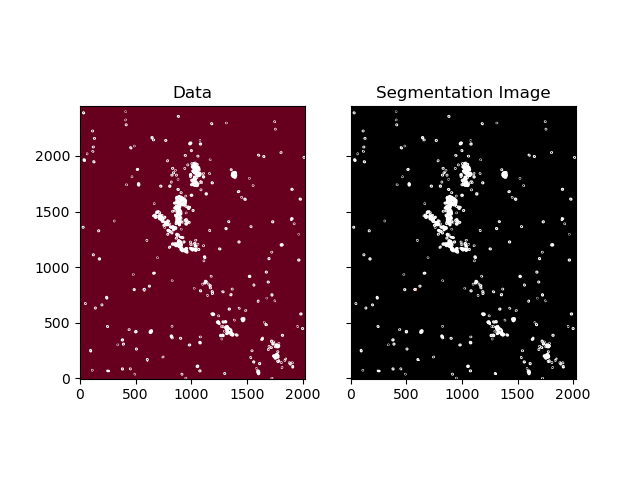

In [23]:
# To check if everything is in order
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
ax1.imshow(F148W_smoothed_data_for_visualization - F148W_bkg.background, 
           origin='lower', 
           cmap = 'RdBu', 
           vmin = 1 * np.mean(F148W_bkg.background_rms),
           vmax = 3 * np.mean(F148W_bkg.background_rms))

ax1.set_title('Data')

cmap = F148W_segm_deblend.make_cmap(seed = 123)
ax2.imshow(F148W_segm_deblend, 
           origin = 'lower', 
           cmap = cmap,
           interpolation = 'nearest')

ax2.set_title('Segmentation Image')

for aperture in F148W_cat.kron_aperture:
    if aperture is not None:
        aperture.plot(axes=ax1, color='white', lw=1.5)
        aperture.plot(axes=ax2, color='white', lw=1.5)

In [24]:
master_tbl.write('cenA_catalog.fits', format = 'fits', overwrite = True)
print(len(master_tbl))

417


In [25]:
GAIA_stars_tbl = XMatch.query(cat1 = master_tbl,
                              cat2 = 'vizier:I/352/gedr3dis',
                              max_distance = 1 * u.arcsec, 
                              colRA1 = 'RA_J2000',
                              colDec1 = 'DEC_J2000')

not_stars_tbl = setdiff(master_tbl, GAIA_stars_tbl, keys = 'label')

In [26]:
print(len(GAIA_stars_tbl))
GAIA_stars_tbl.write('GAIA_stars.fits', format = 'fits', overwrite = True)

63


In [27]:
simbad_matched_tbl = XMatch.query(cat1 = not_stars_tbl,
                                  cat2 = 'simbad',
                                  max_distance = 1 * u.arcsec, 
                                  colRA1 = 'RA_J2000',
                                  colDec1 = 'DEC_J2000')

faraway_objects_tbl = simbad_matched_tbl[simbad_matched_tbl['redshift'] > 0.003]

In [28]:
print(len(faraway_objects_tbl))
faraway_objects_tbl.write('simbad_faraway_objects.fits', format = 'fits', overwrite = True)

2


In [29]:
final_table = setdiff(not_stars_tbl, faraway_objects_tbl, keys = 'label')
final_table.write('final_table.fits', format = 'fits', overwrite = True)

In [30]:
final_table

label,RA_J2000,DEC_J2000,F148W_calibrated_flux,F148W_calibrated_fluxerr,F148W_ext_corrected_flux,F148W_ext_corrected_fluxerr,F148W_gini,F148W_fwhm,F148W_elongation,F148W_area_kpc_square,N219M_calibrated_flux,N219M_calibrated_fluxerr,N219M_ext_corrected_flux,N219M_ext_corrected_fluxerr,N245M_calibrated_flux,N245M_calibrated_fluxerr,N245M_ext_corrected_flux,N245M_ext_corrected_fluxerr,N279N_calibrated_flux,N279N_calibrated_fluxerr,N279N_ext_corrected_flux,N279N_ext_corrected_fluxerr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,201.45528218154826,-43.00050609140218,2.447867444493139e-18,6.931573338343301e-19,4.837045888200783e-18,1.369695830157098e-18,0.206158512198195,0.8218162029924062,3.175433309912802,0.0002948921503171298,1.7209293080771158e-18,9.525562091642152e-19,3.654259076486171e-18,2.0226787683051148e-18,2.8384361526850967e-18,9.547629543647008e-19,5.252370214092663e-18,1.7667364116259615e-18,2.7736772655322838e-18,1.108801263791675e-18,4.548477975613472e-18,1.8182930618357177e-18
2,201.57772702138087,-43.00155756727491,2.1237253139656775e-18,7.095833108251607e-19,4.19653311730393e-18,1.4021539620881877e-18,0.4499976622428682,0.6168525297360137,1.5976881554007674,0.0004128490104439817,8.276493472380035e-19,8.236066543220965e-19,1.757448795309146e-18,1.748864452412513e-18,2.820926652065743e-18,1.0788737580838743e-18,5.2199698448154714e-18,1.99639663776317e-18,2.281264865865645e-18,1.2113303671468707e-18,3.740984262254983e-18,1.986427752293661e-18
4,201.58336336046176,-42.997549346882145,4.6372356724837334e-18,1.0443159680716506e-18,9.163291007716292e-18,2.0635938725797112e-18,0.41644352087689124,1.0191341935964344,1.3360351009234532,0.0008846764509513893,3.8513119421980445e-18,1.5545521092284438e-18,8.177960335211014e-18,3.30097007957064e-18,1.1660732496146981e-18,7.489865726109959e-19,2.15775450785909e-18,1.3859585183960944e-18,2.574034137807456e-18,1.3391662198751668e-18,4.221088635576212e-18,2.1960622933608738e-18
5,201.6503584587494,-42.9981889264501,2.8768795818800392e-18,7.935772130816569e-19,5.68478435533221e-18,1.5681279654835592e-18,0.6162637880412943,0.5711668054425275,1.7538462963333237,0.00047182744050740764,2.460482754364965e-19,7.20459143908436e-19,5.224643101535793e-19,1.529838764153864e-18,9.261515170660896e-19,4.890423834560412e-19,1.713792518240357e-18,9.049460724573727e-19,1.4198672036748283e-18,9.430429431261782e-19,2.328401643718803e-18,1.5464704961065356e-18
6,201.55787786221492,-42.9938295213131,1.1896886573087507e-17,1.614654885046106e-18,2.3508538589457648e-17,3.190597509740878e-18,0.39920902667571173,1.4472785147358267,1.3363209860539949,0.0019462881920930565,7.865555146301308e-18,2.143881157202001e-18,1.6701892489174863e-17,4.552364319000853e-18,5.784131599234398e-18,1.23850242188593e-18,1.0703217860818091e-17,2.2917807133486628e-18,1.6841465184255605e-18,1.5763701294748088e-18,2.7617861104308097e-18,2.5850465389148822e-18
7,201.68846111222166,-42.99521500198434,5.391354304523766e-18,1.1022464879328258e-18,1.0653447852822805e-17,2.1780659954580205e-18,0.447094365482596,1.792087728729324,3.3725552777424617,0.0009436548810148153,1.0234963673941795e-18,1.058189045257531e-18,2.1733146578111558e-18,2.2469818516782975e-18,1.7780953447155485e-18,8.898997956426834e-19,3.2902677826894527e-18,1.6467106986849787e-18,2.0581910333205453e-18,1.20920405011376e-18,3.375171546090848e-18,1.9829408627717758e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,201.56979120880274,-42.78580454458603,3.54829477205224e-17,2.8617427840381273e-18,7.011517178305988e-17,5.654873672902709e-18,0.3936016548837551,3.2564156278765886,1.8045383967365753,0.006782519457293985,2.548674898412842e-17,3.97723965589464e-18,5.411912236502079e-17,8.44535800726944e-18,1.8911218319821192e-17,2.2740482336529847e-18,3.4994170899799737e-17,4.208001366016311e